# EVs - One Electric Vehicle Dataset - Smaller

## Úvod

V našom projekte sme si zvolili dataset obsahujúci informácie o elektrických vozidlách.

Dataset: https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset (ElectricCarData_Clean.csv)

Načítanie knížnic

### Analýza dát

In [1798]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import math 
import scipy as sc

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

from collections import Counter
from yellowbrick.cluster import KElbowVisualizer

Načítanie datasetu

In [1799]:
original_data = pd.read_csv("ElectricCarData_Clean.csv")
data = pd.read_csv("ElectricCarData_Clean.csv")

### Funkcie

Úprava stĺpcov a nahradenie invalidnej hodnoty

In [1800]:
def EditColumns(data):
    data = data.drop(['PlugType'], axis = 1)

    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(str).str.replace('-','0')
    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

    data.columns = data.columns.str.replace('AccelSec', 'Acceleration 0-100 (s)')
    data.columns = data.columns.str.replace('TopSpeed_KmH', 'TopSpeed (km/h)')
    data.columns = data.columns.str.replace('Range_Km', 'Range (km)')
    data.columns = data.columns.str.replace('Efficiency_WhKm', 'Efficiency (Wh/km)')
    data.columns = data.columns.str.replace('FastCharge_KmH', 'FastCharge (km/h)')
    return data

In [1801]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [1802]:
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    
    return data[(data > upper) | (data < lower)]

In [1803]:
data = EditColumns(data)

Ukážka datasetu

In [1804]:
data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,Yes,RWD,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Hatchback,B,4,32997


Informácie o datasete

In [1805]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    object 
 8   PowerTrain              103 non-null    object 
 9   BodyStyle               103 non-null    object 
 10  Segment                 103 non-null    object 
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 10.6+ KB


Dataset má 103 riadkov a 14 stĺpcov.

Dataset je zložený z atribútov:
- 6 spojitých
    - 1x float
    - 5x int
- 8 kategorických
    - 8x object
    
Nenachádzajú sa tu nulové hodnoty.

Deskriptívne štatistiky datasetu

In [1806]:
data.describe()

,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,434.563107,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,219.660061,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,260.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,440.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,555.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,940.000000,7.000000,215000.000000


In [1807]:
# A	mini
# B	small
# C	medium
# D	large
# E	executive
# F	luxury

# J	SUV
# M	MPV

# N	VAN
# S	sports

In [1808]:
# A watt hour per kilometer (Wh/km) measures how many watt hours of electricity a car consumes to travel distance of 1 kilometer.
# 1 Wh/km = 1 000 km/kWh

In [1809]:
data.isnull().sum()

Brand                     0
Model                     0
Acceleration 0-100 (s)    0
TopSpeed (km/h)           0
Range (km)                0
Efficiency (Wh/km)        0
FastCharge (km/h)         0
RapidCharge               0
PowerTrain                0
BodyStyle                 0
Segment                   0
Seats                     0
PriceEuro                 0
dtype: int64

In [1810]:
def ReplaceStringValues(data):
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('AWD','3')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('RWD','2')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('FWD','1')
    data['PowerTrain'] = data['PowerTrain'].astype(int)

    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('Yes','1')
    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('No','0')
    data['RapidCharge'] = data['RapidCharge'].astype(int)

    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Hatchback','1')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Liftback','2')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Sedan','3')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Station','4')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Cabrio','5')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SUV','6')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('MPV','7')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SPV','8')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Pickup','9')
    data['BodyStyle'] = data['BodyStyle'].astype(int)

    data['Segment'] = data['Segment'].astype(str).str.replace('A','1')
    data['Segment'] = data['Segment'].astype(str).str.replace('B','2')
    data['Segment'] = data['Segment'].astype(str).str.replace('C','3')
    data['Segment'] = data['Segment'].astype(str).str.replace('D','4')
    data['Segment'] = data['Segment'].astype(str).str.replace('E','5')
    data['Segment'] = data['Segment'].astype(str).str.replace('F','6')
    data['Segment'] = data['Segment'].astype(str).str.replace('N','7')
    data['Segment'] = data['Segment'].astype(str).str.replace('S','8')
    data['Segment'] = data['Segment'].astype(int)

    # data.drop(data.index[data['BodyStyle'] == 0], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 1], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 2], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 3], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 4], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 7], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 6], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 8], inplace=True)
    return data

In [1811]:
data = ReplaceStringValues(data)

In [1812]:
normalized_data = data
# for column in data.columns:
#     if(column != 'Brand' and column != 'Model' and column != 'PowerTrain' and 
#        column != 'RapidCharge' and column != 'BodyStyle' and column != 'Segment'):
#         normalized_data[column]  = NormalizeData(data[column])

<AxesSubplot:>

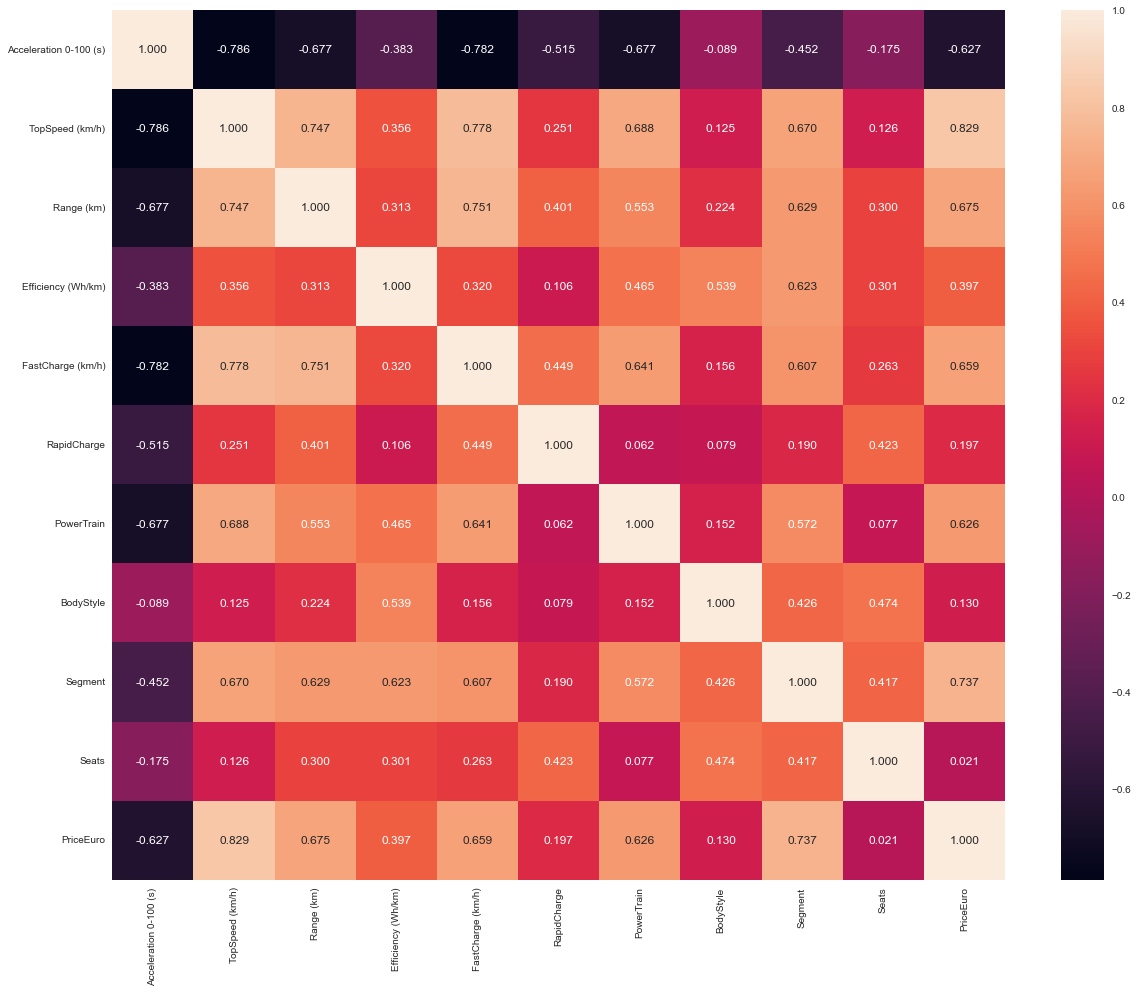

In [1813]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(normalized_data.corr(), ax = ax, annot = True, fmt = ".3f")

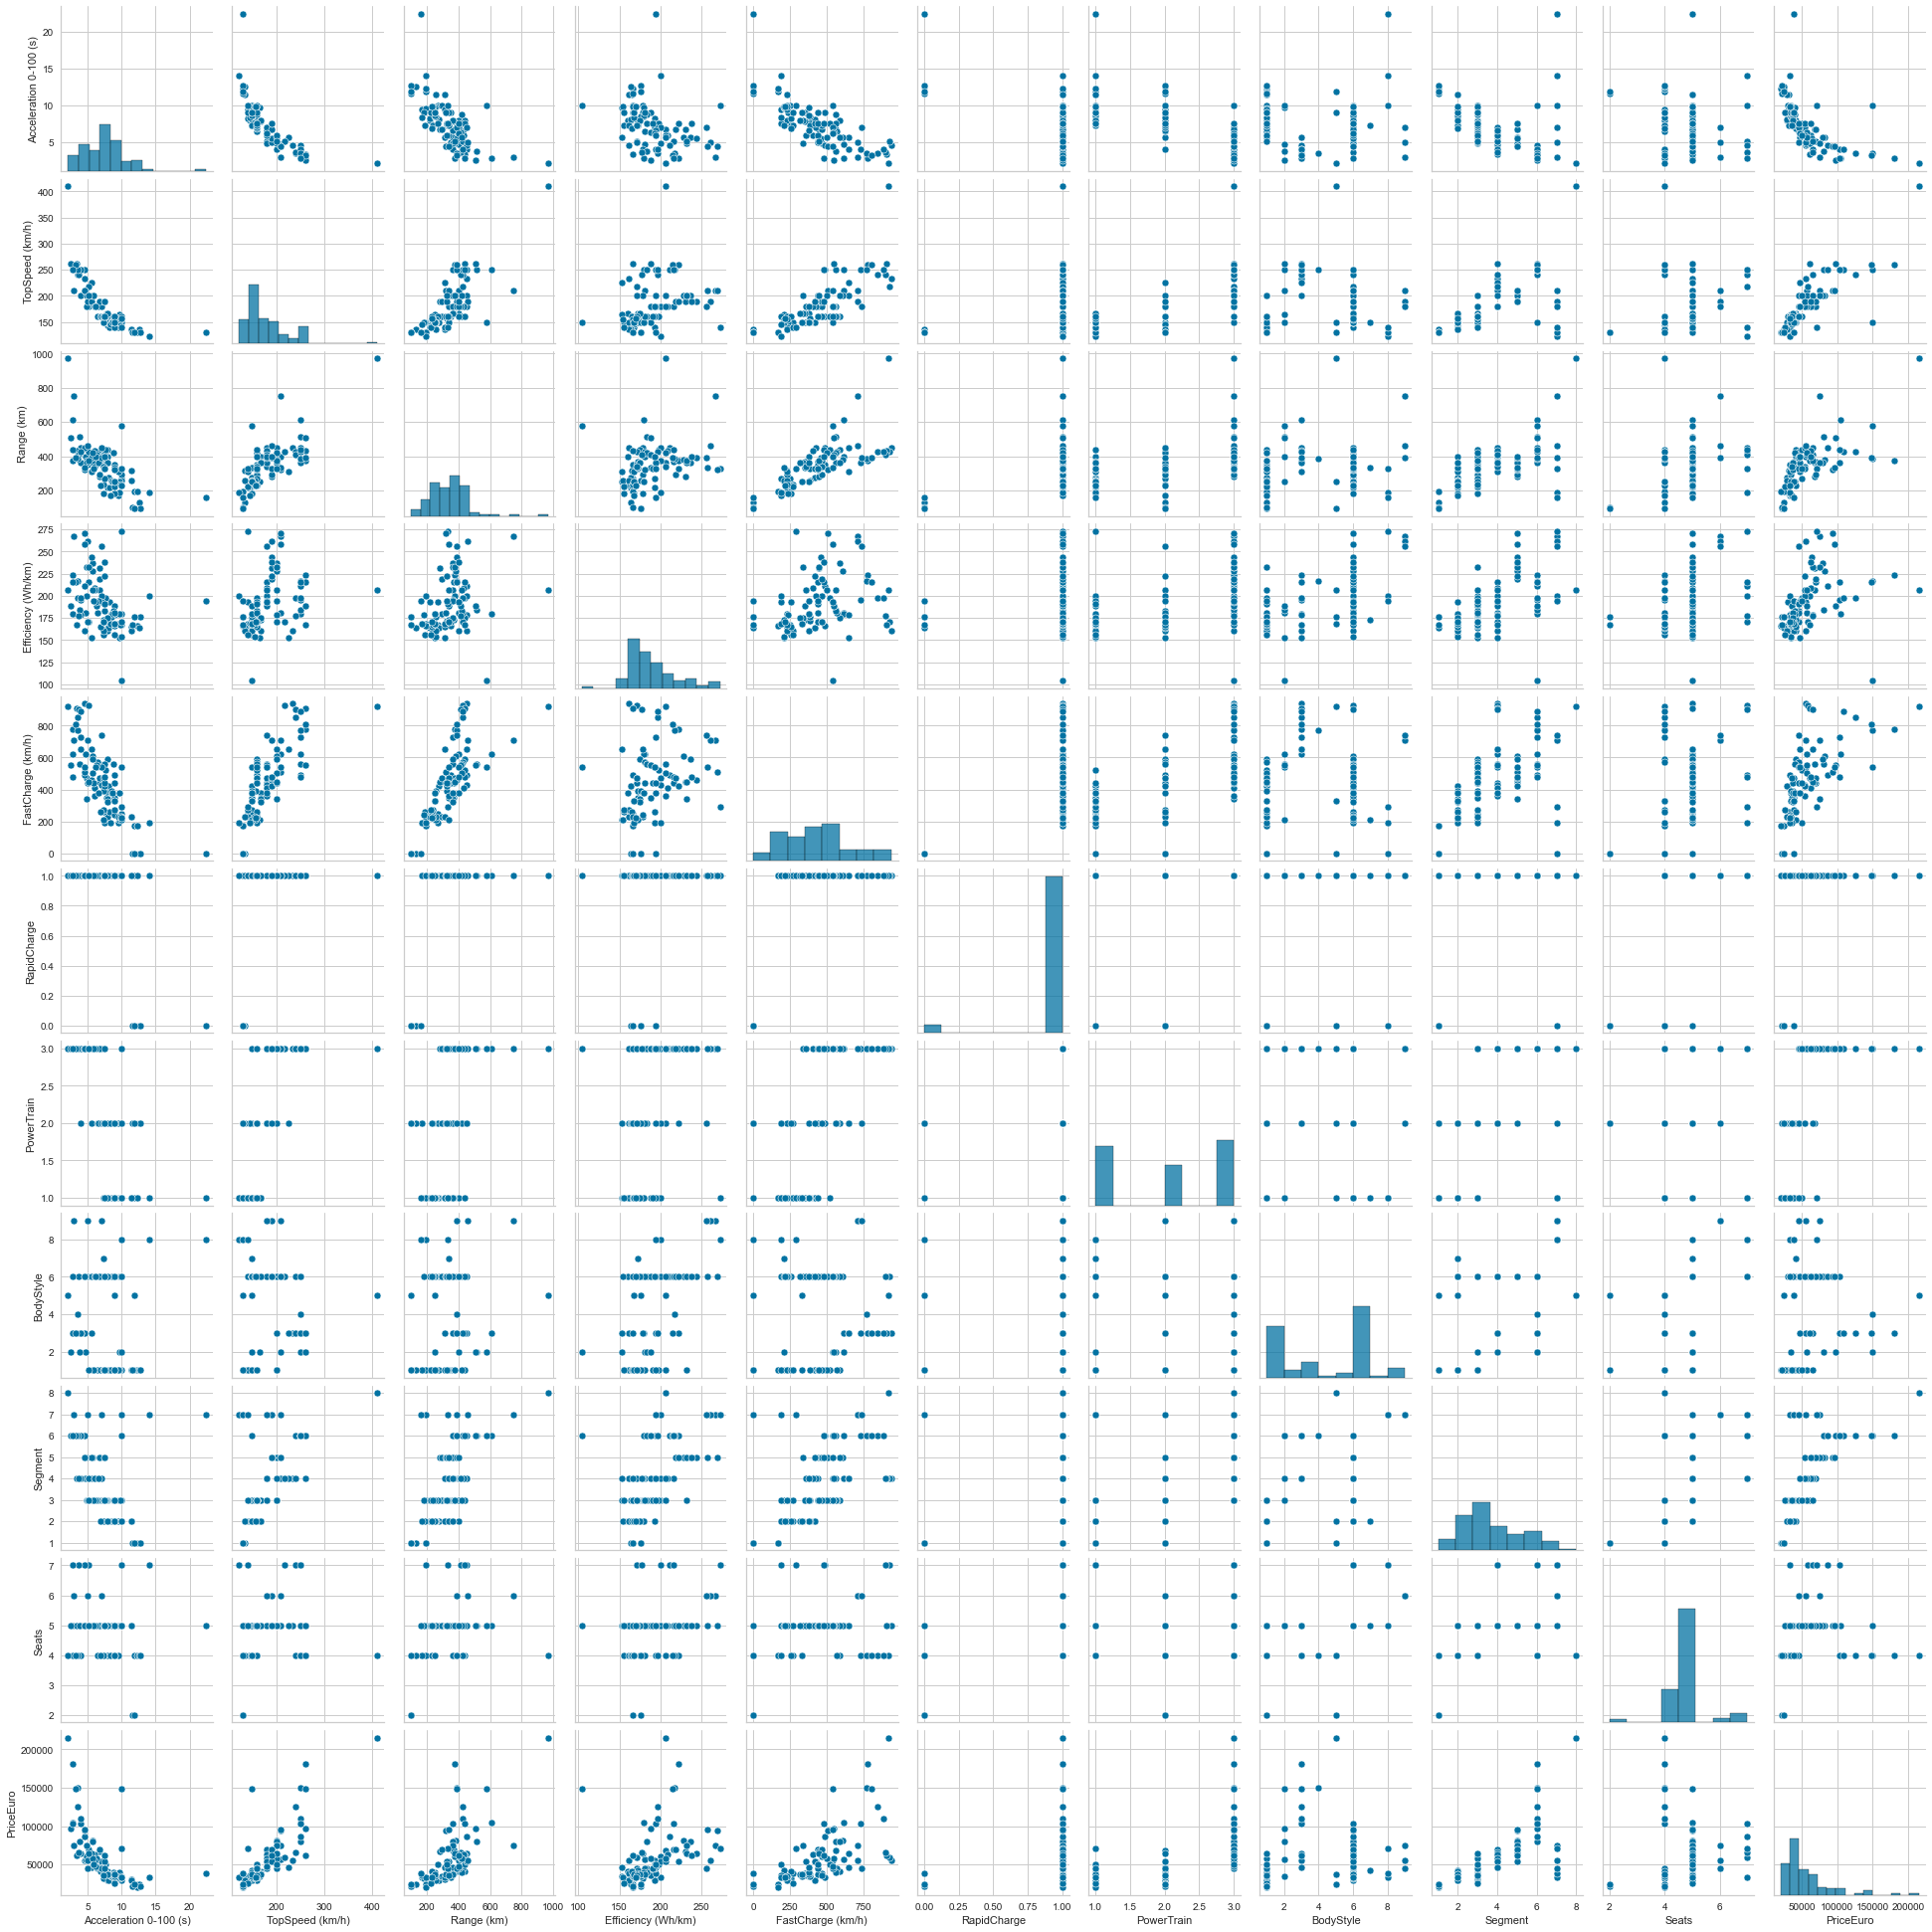

In [1814]:
sns.pairplot(normalized_data)

In [1815]:
# sns.pairplot(normalized_data, hue = "PowerTrain")

# 1. hypotéza 
Vozidla, ktore maju pohananu len 1 napravu (FWD / RWD), majú zrýchlenie z 0-100 dlhsie ako 8 sekund.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerTrain', ylabel='Acceleration 0-100 (s)'>

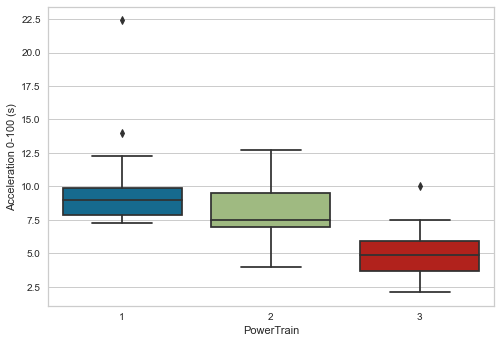

In [1816]:
sns.boxplot("PowerTrain", "Acceleration 0-100 (s)", data=normalized_data)

In [1817]:
Acceleration_FWD = normalized_data.loc[normalized_data['PowerTrain']==1, 'Acceleration 0-100 (s)']
Acceleration_RWD = normalized_data.loc[normalized_data['PowerTrain']==2, 'Acceleration 0-100 (s)']
Acceleration_AWD = normalized_data.loc[normalized_data['PowerTrain']==3, 'Acceleration 0-100 (s)']
Acceleration_FRWD = Acceleration_FWD
Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)

C:\Users\Martin\AppData\Local\Temp\ipykernel_29832\255953600.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)


Rovnaká hypotéza, ale dáta sú kvôli normálnosti rozdelenia zlogaritmované

Logistická regresia

Skúmame, ako dobre vieme predikovať hodnoty akcelerácie pre vozidlá s rôznym pohonom.

In [1818]:
logRegData = data
logRegData['PowerTrain'].replace(to_replace=['AWD','FWD','RWD'], value = [0, 1, 2], inplace = True)
y = data[['PowerTrain']]
x = data[['Acceleration 0-100 (s)']]

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

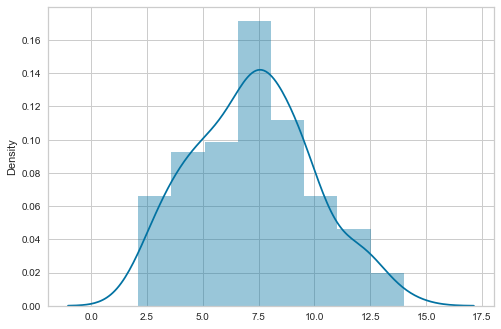

In [1819]:
outl = identify_outliers(data['Acceleration 0-100 (s)'])
xdata = data
xdata = xdata.drop(outl.index)
sns.distplot(xdata[['Acceleration 0-100 (s)']])

In [1820]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
iris=load_iris()
Y = xdata[['PowerTrain']]
X = xdata[['Acceleration 0-100 (s)']]
print("Size of Dataset {}".format(len(xdata)))
logreg=LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)
logreg.fit(x_train,y_train)
# print(logreg.intercept_)
# print(logreg.coef_)
predict=logreg.predict(x_test)
print("Accuracy score on training set is {}".format(accuracy_score(logreg.predict(x_train),y_train)))
print("Accuracy score on test set is {}".format(accuracy_score(predict,y_test)))

Size of Dataset 102
Accuracy score on training set is 0.75
Accuracy score on test set is 0.7096774193548387


C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Rozdelíme si dáta na trénovaciu a testovaciu časť.

In [1821]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

Natrénovanie logistickej regresie

In [1822]:
log = LogisticRegression()
log.fit(x_train, y_train.values.ravel())
prediction = log.predict(x_test)

Vypočítanie chyby RMSE

In [1823]:
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("Error: ", rmse)

Error:  0.5388159060803247


Vypočítanie skóre R2

In [1824]:
r2 = (r2_score(y_test, prediction))
print("R2 score: ", r2)

R2 score:  0.581081081081081


Vypočítanie úspešnosti modelu pomocou accuracy score

In [1825]:
score = accuracy_score(y_test, prediction)
print("Accuracy score: ", score)

Accuracy score:  0.7096774193548387


Zobrazenie confusion matice

In [1826]:
confusion_matrix(y_test, prediction)

array([[ 9,  0,  0],
       [ 6,  0,  3],
       [ 0,  0, 13]], dtype=int64)

Na základe logistickej regresie sa zdá model relatívne dobrý, preto ešte hypotézu nezamietame a prejdeme na vykonávanie testov.

# 2. hypotéza 
Vozidla kategorie SUV maju priemerne vyssiu spotrebu energie ako vozidla inych kategórii

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BodyStyle', ylabel='Efficiency (Wh/km)'>

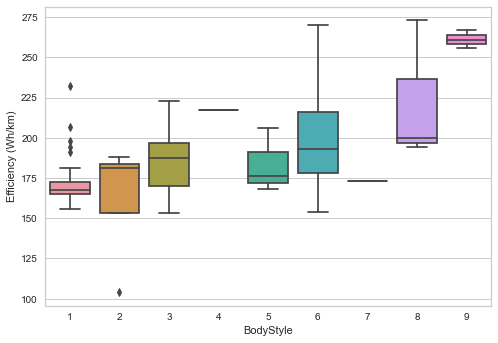

In [1827]:
sns.boxplot("BodyStyle", "Efficiency (Wh/km)", data=normalized_data)

In [1828]:
Hatchback = normalized_data.loc[normalized_data['BodyStyle']==1, 'Efficiency (Wh/km)']
Liftback = normalized_data.loc[normalized_data['BodyStyle']==2, 'Efficiency (Wh/km)']
Sedan = normalized_data.loc[normalized_data['BodyStyle']==3, 'Efficiency (Wh/km)']
Station = normalized_data.loc[normalized_data['BodyStyle']==4, 'Efficiency (Wh/km)']
Cabrio = normalized_data.loc[normalized_data['BodyStyle']==5, 'Efficiency (Wh/km)']
SUV = normalized_data.loc[normalized_data['BodyStyle']==6, 'Efficiency (Wh/km)']
MPV = normalized_data.loc[normalized_data['BodyStyle']==7, 'Efficiency (Wh/km)']
SPV = normalized_data.loc[normalized_data['BodyStyle']==8, 'Efficiency (Wh/km)']
Pickup = normalized_data.loc[normalized_data['BodyStyle']==9, 'Efficiency (Wh/km)']

Other_BodyStyles = Hatchback
Other_BodyStyles = Other_BodyStyles.append(Liftback)
Other_BodyStyles = Other_BodyStyles.append(Sedan)
Other_BodyStyles = Other_BodyStyles.append(Station)
Other_BodyStyles = Other_BodyStyles.append(Cabrio)
Other_BodyStyles = Other_BodyStyles.append(MPV)
Other_BodyStyles = Other_BodyStyles.append(SPV)
Other_BodyStyles = Other_BodyStyles.append(Pickup)

# SUV = np.log(SUV)
# Other_BodyStyles = np.log(Other_BodyStyles)

C:\Users\Martin\AppData\Local\Temp\ipykernel_29832\1451376620.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Liftback)
C:\Users\Martin\AppData\Local\Temp\ipykernel_29832\1451376620.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Sedan)
C:\Users\Martin\AppData\Local\Temp\ipykernel_29832\1451376620.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Station)
C:\Users\Martin\AppData\Local\Temp\ipykernel_29832\1451376620.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_

# Hypotéza
Chceme zistiť či cena závisí viacej na:

• kategórii vozidla vzhľadom na rýchlosť (TopSpeed a Acceleration), 

• kategórii vozidla vzhľadom na schopnosti batérie - prejdenia vzdialenosti na 1 nabitie, kapacity nabitia batérie za hodinu (Range a FastCharge). 

Vozidlá si pomocou k means rozdelíme do 2 kategorii:
    - spojenim topspeed a acceleration
    - spojenim range a fastcharge

### Acceleration - TopSpeed

In [1829]:
km_data = data

In [1830]:
ACC_outliers = identify_outliers(km_data["Acceleration 0-100 (s)"])
km_data = km_data.drop(ACC_outliers.index)

TS_outliers = identify_outliers(km_data["TopSpeed (km/h)"])
km_data = km_data.drop(TS_outliers.index)

In [1831]:
df = pd.DataFrame(km_data, columns=["Acceleration 0-100 (s)", "TopSpeed (km/h)"])

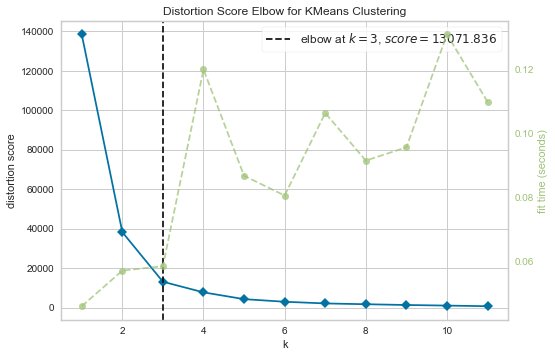

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1832]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [1833]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [1834]:
kmeans.labels_ = np.where(kmeans.labels_ == 1, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 2, 1, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 2, kmeans.labels_)

In [1835]:
Counter(kmeans.labels_)

Counter({2: 15, 0: 56, 1: 30})

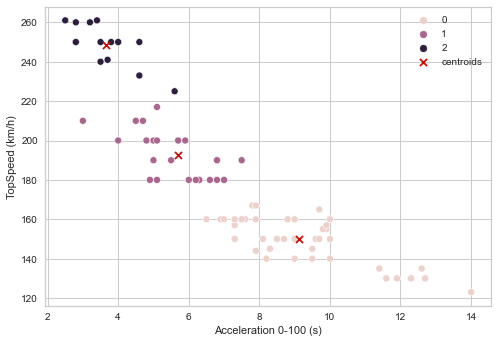

In [1836]:
sns.scatterplot(data=df, x="Acceleration 0-100 (s)", y="TopSpeed (km/h)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

In [1837]:
km_data.insert(4, 'Acceleration-TopSpeed category', value = kmeans.labels_)

### Range - FastCharge

In [1838]:
# km_data = data

R_outliers = identify_outliers(km_data["Range (km)"])
km_data = km_data.drop(R_outliers.index)

FCH_outliers = identify_outliers(km_data["FastCharge (km/h)"])
km_data = km_data.drop(FCH_outliers.index)
km_data.drop(km_data.index[km_data['FastCharge (km/h)'] == 0], inplace=True)
# km_data.drop(km_data.index[km_data['Range (km)'] >= 500], inplace=True)

In [1839]:
df = pd.DataFrame(km_data, columns=["FastCharge (km/h)", "Range (km)"])

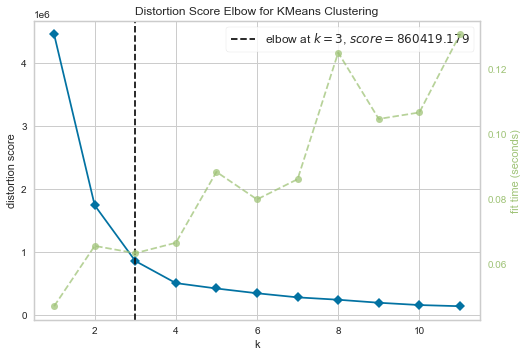

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1840]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [1841]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [1842]:
kmeans.labels_ = np.where(kmeans.labels_ == 0, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 1, 0, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 1, kmeans.labels_)


In [1843]:
Counter(kmeans.labels_)

Counter({2: 12, 0: 38, 1: 46})

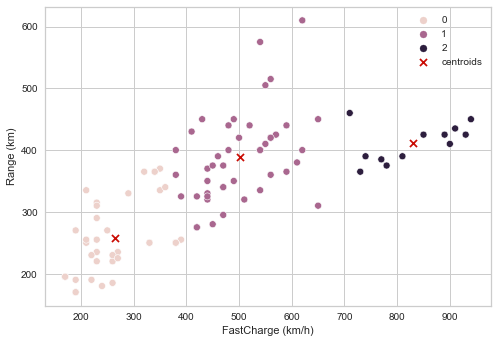

In [1844]:
sns.scatterplot(data=df, x="FastCharge (km/h)", y="Range (km)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

In [1845]:
km_data.insert(8, 'Range-FastCharge category', value = kmeans.labels_)

In [1846]:
x=km_data[['Acceleration-TopSpeed category','Range-FastCharge category']]
y=km_data['PriceEuro']
x= sm.add_constant(x)
results = sm.OLS(y,x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     56.41
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           9.07e-17
Time:                        16:17:06   Log-Likelihood:                -1088.9
No. Observations:                  96   AIC:                             2184.
Df Residuals:                      93   BIC:                             2192.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3.432e+04   3132.737     10.957      0.000    2.81e+04    4.05e+04
Acceleration-TopSpeed category  2.403e+04   4211.389      5.706      0.000    1.57e+04    3.24e+04
Range-FastCharge category       8784.2499   4666.272      1.882      0.063    -482.041    1.81e+04
==============================================================================
Omnibus:                       64.286   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.197
Skew:                           2.087   Prob(JB):                     1.02e-83
Kurtosis:                      11.839   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Väčšia (nevýznamná) p-hodnota naznačuje, že zmeny v prediktore nie sú spojené so zmenami v odpovedi.

Vo výstupe nižšie vidíme, že prediktorová premenná Acceleration-TopSpeed category je štatisticky významná, pretože p-hodnota je 0,000 (je menšia ako bežná hladina alfa 0,05).

r-squared -> na zaklade 54.8% x hodnot viem vyjadrit y hodnotu (price) 

 # --------------------

52.23880597014925
58.620689655172406
[[17  0  0]
 [ 8  0  0]
 [ 4  0  0]]


<AxesSubplot:>

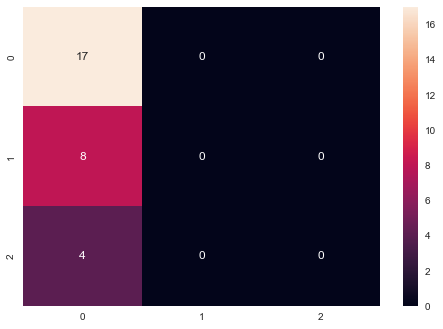

In [1847]:
y1 = km_data[['Acceleration-TopSpeed category']]
x1 = km_data[['PriceEuro']]

# sns.regplot(x=x1, y=y1, data=km_data, ci=None)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 7)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print(score*100)

score=accuracy_score(y1_test,pred2)
print(score*100)

# class_report=classification_report(y1_test, pred2)
# print(class_report)

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

43.28358208955223
58.620689655172406
[[ 0 10  0]
 [ 0 17  0]
 [ 0  2  0]]


<AxesSubplot:>

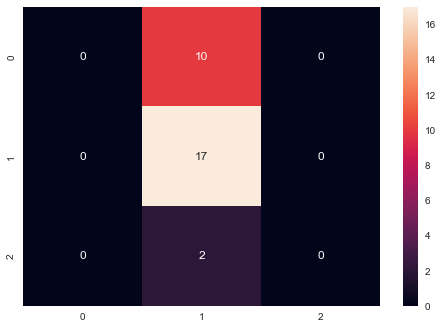

In [1848]:
y1 = km_data[['Range-FastCharge category']]
x1 = km_data[['PriceEuro']]

# sns.regplot(x=x1, y=y1, data=km_data, ci=None)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 7)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print(score*100)

score=accuracy_score(y1_test,pred2)
print(score*100)

# class_report=classification_report(y1_test, pred2)
# print(class_report)

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

# Hypotéza

81.3303003521656


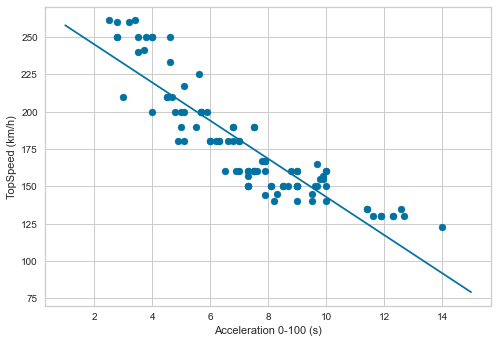

In [1857]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])
x = x.drop(TS_outliers.index)
y = y.drop(TS_outliers.index)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# r2=(r2_score(y_train,pred))
# print(r2*100)

r2=(r2_score(y_test,pred))
print(r2*100)


# plt.scatter(x, y, color = 'blue')
 
# plt.plot(x.values, lr.predict(x), color = 'red')
# plt.title('Linear Regression')
# plt.xlabel('Acceleration 0-100 (s)')
# plt.ylabel('TopSpeed (km/h)')
 
# plt.show()


mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 1))

myline = np.linspace(1, 15, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

87.8712225689115


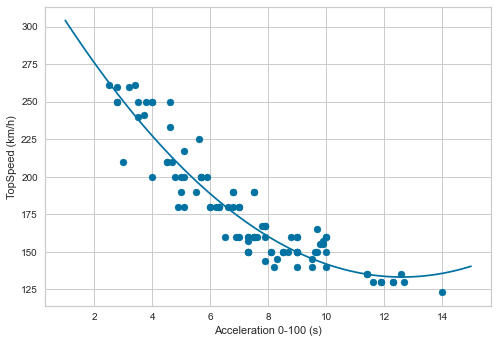

In [1858]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])
x = x.drop(TS_outliers.index)
y = y.drop(TS_outliers.index)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print(r2_score(y_test, poly_reg_y_predicted) * 100)


mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 2))

myline = np.linspace(1, 15, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

86.94254281914945


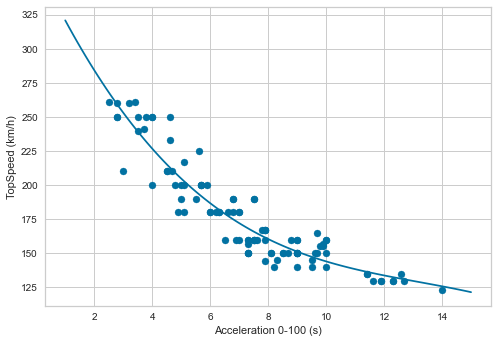

In [1859]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])
x = x.drop(TS_outliers.index)
y = y.drop(TS_outliers.index)

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print(r2_score(y_test, poly_reg_y_predicted) * 100)


mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 3))

myline = np.linspace(1, 15, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Best degree function

Best degree 2 with RMSE 13.101125578163673


Text(0, 0.5, 'RMSE')

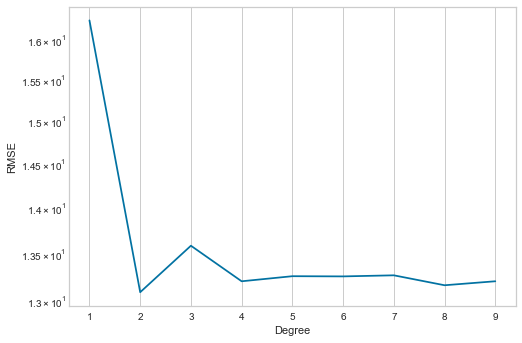

In [1852]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])
x = x.drop(TS_outliers.index)
y = y.drop(TS_outliers.index)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 50)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

In [1853]:
x=data[['Acceleration 0-100 (s)','TopSpeed (km/h)','Range (km)','Efficiency (Wh/km)','FastCharge (km/h)']]
y=data['PriceEuro']

from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

In [1854]:
predictedprice = regr.predict([[6.8, 180, 360, 206, 560]])

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [1855]:
print(predictedprice)

[59019.71031003]
